# Add derived variables
We want to add several derived variables to the NetCDF files. See appendix in paper.

In [1]:
import glob
import sys
import pandas as pd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

### Data loading

In [4]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

## Processing

In [6]:
debug_message = f'\n!!! CHECK DEBUGGING STATUS: \n- Testing 1 basin\n- Testing 1 file\n'

In [8]:
print(debug_message)
for ix,row in cs_meta.iterrows():

    # DEBUGGING
    if ix != 0: continue
    
    # Get shapefile path to determine download coordinates, and forcing destination path
    basin_id, shp_lump_path, shp_dist_path, _, _ = cs.prepare_delineation_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder)
    raw_fold, _, _ = cs.prepare_forcing_outputs(cs_meta, ix, Path(data_path)/cs_basin_folder) # Returns folders only, not file names
    print('--- Now running basin {}. {}'.format(ix, basin_id))
    
    # Check if we need to run downloads for this station at all
    missing = cs.flow_obs_unavailable(cs_unusable, row.Country, row.Station_id)
    if 'iv' in missing and 'dv' in missing: 
        continue # with next station, because we have no observations at all for this station

    # Find the files
    era5_merged_files = sorted(glob.glob(str(raw_fold/'ERA5_[0-9][0-9][0-9][0-9]-[0-9][0-9].nc'))) # list
    
    # Loop over the files and add new variables
    for era5_merged_file in era5_merged_files:
        # DEBUGGING
        if '1950-01' not in era5_merged_file: continue
        cs.add_derived_variables(era5_merged_file)

print(debug_message)


!!! CHECK DEBUGGING STATUS: 
- Testing 1 basin
- Testing 1 file

--- Now running basin 0. CAN_01AD002

!!! CHECK DEBUGGING STATUS: 
- Testing 1 basin
- Testing 1 file



## Sanity checks

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [10]:
check = xr.open_dataset('C:\\Globus endpoint\\CAMELS_spat\\camels-spat-data\\basin_data\\CAN_01AD002\\forcing\\raw\\ERA5_1950-01.nc')

#### Saturation vapor pressure
- Should match Figure 4.1 in Stull (2018)

In [12]:
def saturation_vapor_pressure(T):

    '''Test function for sat vapor pressure'''

    # 0. Constants
    Rv = 461 # [J K-1 kg-1]
    T0 = 273.15 # [K]
    e0 = 0.6113 # [kPa]
    Lv = 2.5*10**6 # [J kg-1], latent heat of vaporization for liquid water
    Ld = 2.83*10**6 # [J kg-1], latent heat of deposition for ice
    Tice = 273.15
    
    # 2. Compute the values
    if T < Tice:
        es = e0*np.exp(Ld/Rv * (1/T0 - 1/T))
    else:
        es = e0*np.exp(Lv/Rv * (1/T0 - 1/T))
    return es

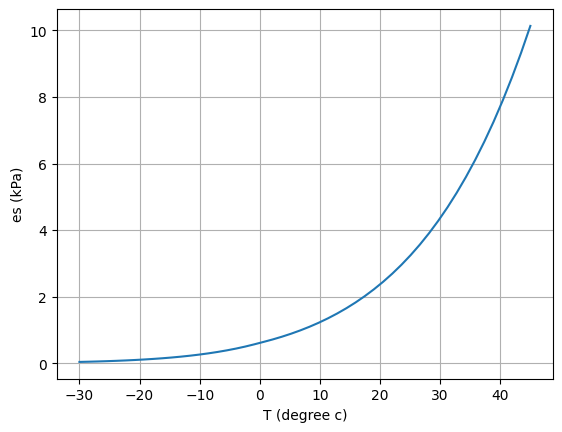

In [13]:
# saturation vapor pressure es
Ts = np.linspace(-30,45) + 273.15
es = [saturation_vapor_pressure(T) for T in Ts]
plt.plot(Ts-273.15,es); plt.grid(); plt.xlabel('T (degree c)'); plt.ylabel('es (kPa)'); # This seems close enough

#### Reflected shortwave
Checks: 
- Should be equal or lower than downward shortwave
- Reasonable values between 0 and several 100s W m-2

In [14]:
(check['reflected_sw'] <= check['msdwswrf']).all().values

array(True)

In [15]:
min = check['reflected_sw'].min().values
max = check['reflected_sw'].max().values
print(f"Min reflected shortwave = {min} W m-2\nMax reflected shortwave = {max} W m-2")

Min reflected shortwave = -0.005916863679885864 W m-2
Max reflected shortwave = 275.44482421875 W m-2


#### Net radiation
Checks:
- Expectation that during daylight hours net radiation should be mostly positive (incoming > outgoing), and negative during nighttime (outgoing > incoming)
- Because times are in UTC and not local, we need to account for this when selecting daylight and nighttime hours

In [16]:
# Find daylight hours by checking incoming shortwave timing
value = check['msdwswrf'].isel(time=range(0,36)).mean(dim=('latitude','longitude'))
index = value.indexes['time']
print('Time                 -  Incoming shortwave > 0')
for i,x in zip(index,value.data):
    if x > 0:
        print(f'{i}  -  {x}')

Time                 -  Incoming shortwave > 0
1950-01-01 13:00:00  -  9.102630615234375
1950-01-01 14:00:00  -  88.05033874511719
1950-01-01 15:00:00  -  203.77130126953125
1950-01-01 16:00:00  -  298.4949035644531
1950-01-01 17:00:00  -  338.5130615234375
1950-01-01 18:00:00  -  318.4136047363281
1950-01-01 19:00:00  -  265.8287048339844
1950-01-01 20:00:00  -  158.12562561035156
1950-01-01 21:00:00  -  39.020992279052734
1950-01-01 22:00:00  -  0.0004162979021202773


In [17]:
# We'll ignore the first hour and last two hours because values are very small
daylight_hours = range(14,21)

In [18]:
# subset to day and night
daytime = check['net_radiation'].sel(time=check.time.dt.hour.isin(daylight_hours))
nighttime = check['net_radiation'].sel(time=~check.time.dt.hour.isin(daylight_hours))

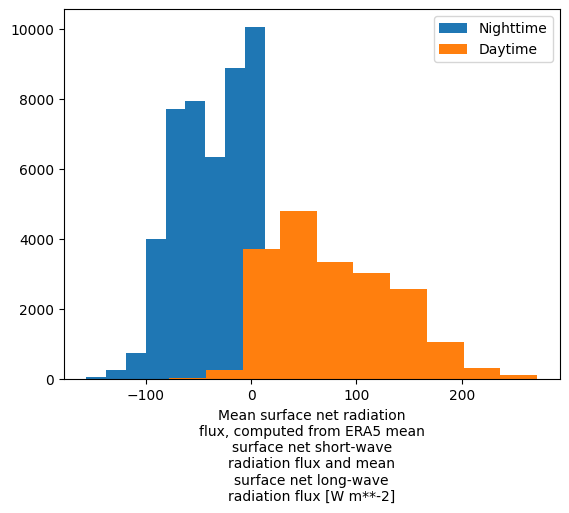

In [19]:
ax = plt.subplot()
nighttime.plot(ax=ax, label='Nighttime')
daytime.plot(ax=ax, label='Daytime')
ax.legend()

#### Vapor pressure
- Should not exceed saturation vapor pressure levels at a given temperature (overly much)

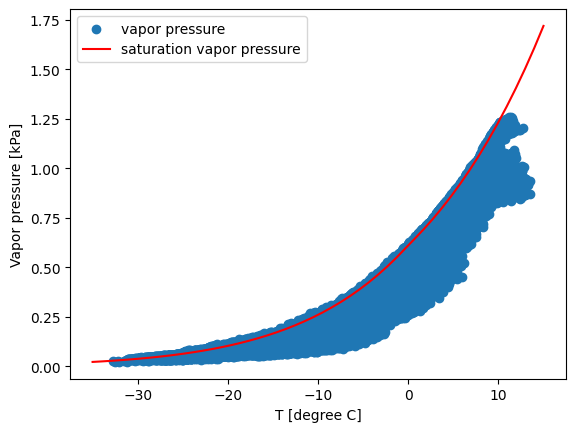

In [20]:
# vapor pressure values
t = check['t'] - 273.15 # [C] to [K]
e = check['e']

# saturation vapor pressure for comparison
Ts = np.linspace(-35,15) + 273.15
es = [saturation_vapor_pressure(T) for T in Ts]

# figure
plt.scatter(t,e, label='vapor pressure'); plt.plot(Ts-273.15,es, label='saturation vapor pressure', color='r')
plt.legend(); plt.xlabel('T [degree C]'); plt.ylabel('Vapor pressure [kPa]');

#### Relative humidity
Checks:
- Feasible range [0,100], with some wiggle room for supersaturation

(array([  275.,  1423.,  5189.,  8924.,  9542., 11709., 15257., 12616.,
          500.,    37.]),
 array([0.27027634, 0.36546308, 0.46064979, 0.55583656, 0.65102327,
        0.74620998, 0.84139675, 0.93658346, 1.03177023, 1.12695694,
        1.22214365]),
 <BarContainer object of 10 artists>)

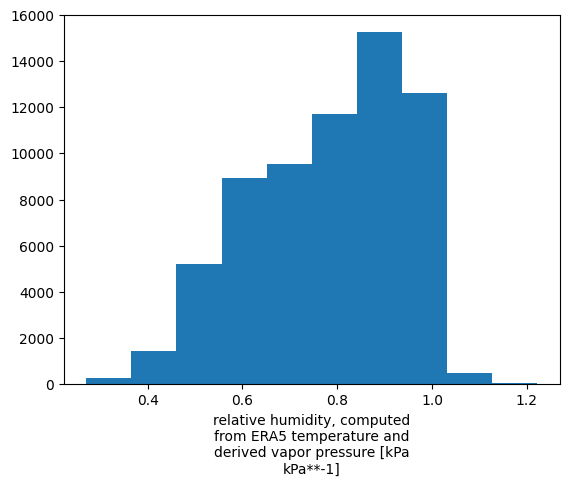

In [21]:
# Relative humidity values
check['rh'].plot()

In [22]:
# Some stats
pd = ((check['rh'] > 1).sum() / (check['rh'] > 0).sum()).values * 100
mv = check['rh'].where(check['rh'] > 1).mean().values
print(f'RH > 1 in {pd:.2f}% of cases')
print(f'Mean RH if above 1 = {mv:.2f} [-]')

RH > 1 in 2.78% of cases
Mean RH if above 1 = 1.03 [-]


#### Mean wind speed
- Should be zero or higher
- Should equal or exceed either individual component
- Physical realistic values are in the range of 0 to 140 km/h (https://www.canada.ca/en/environment-climate-change/services/general-marine-weather-information/understanding-forecasts/beaufort-wind-scale-table.html). 140 km/h ~= 39 m/s

In [23]:
# Everything equal to or larger than zero?
(check['w'] >= 0).all().values

array(True)

In [24]:
# Fraction of values equal to or larger than U-component
((check['w'] >= check['u']).sum() / (check['w'] >= 0).sum()).values

array(1.)

In [25]:
# Fraction of values equal to or larger than V-component
((check['w'] >= check['v']).sum() / (check['w'] >= 0).sum()).values

array(1.)

(array([5.2750e+03, 2.4866e+04, 1.5367e+04, 1.0764e+04, 6.0640e+03,
        2.2450e+03, 6.0600e+02, 1.8100e+02, 8.2000e+01, 2.2000e+01]),
 array([ 0.02181525,  1.25607646,  2.49033761,  3.72459888,  4.9588604 ,
         6.19312143,  7.42738247,  8.66164398,  9.89590549, 11.13016605,
        12.36442757]),
 <BarContainer object of 10 artists>)

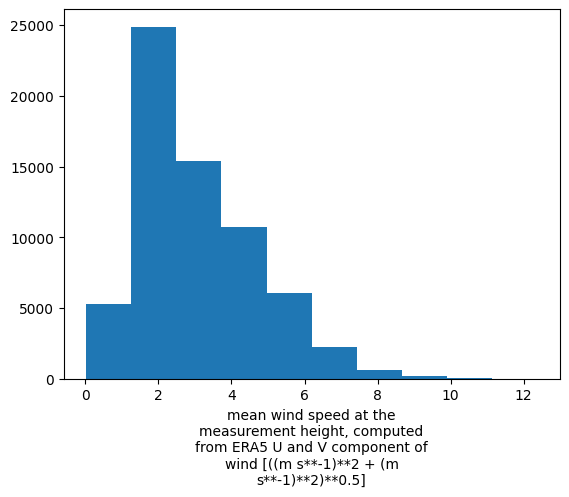

In [26]:
# Within reasonable limits? (< 40 m/s)
check['w'].plot()

In [27]:
check.close()